# Fitting and forecasting

To use `bluebonnet.forecast` in a project:

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
from scipy.misc import derivative
import pandas as pd
import matplotlib.pyplot as plt

import bluebonnet as bb
from bluebonnet.flow import (
    IdealReservoir,
    FlowProperties,
    SinglePhaseReservoir,
    RelPermParams,
)
from bluebonnet.forecast import Bounds, ForecasterOnePhase


## Ideal gas

In [2]:
# Get ideal gas recovery
t_end = 6
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2
res_ideal = IdealReservoir(50, 1000, 9000, None)
res_ideal.simulate(time)
rf_ideal = res_ideal.recovery_factor()
rf_func = interp1d(time, rf_ideal, bounds_error=False, fill_value=(0, rf_ideal[-1]))

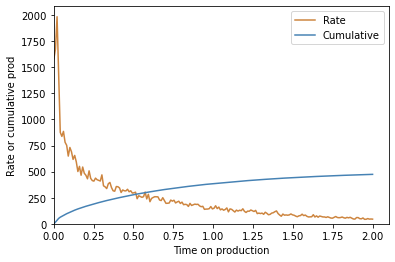

In [3]:
# Create test production to fit to
time_on_production = np.linspace(0.001, 2, 200)
tau_test = 2
M_test = 300
true_prod = M_test * derivative(rf_func, time_on_production / tau_test, dx=0.01)
production = true_prod * np.random.default_rng(42).normal(
    1, 0.1, size=len(time_on_production)
)
time_on_production = time_on_production  # [1:]
cum_production = cumtrapz(production, time_on_production, initial=0)

fig, ax = plt.subplots()
ax.plot(time_on_production, production, color="peru", label="Rate")
ax.plot(time_on_production, cum_production, color="steelblue", label="Cumulative")
ax.set(
    xlabel="Time on production",
    ylabel="Rate or cumulative prod",
    xlim=(0, None),
    ylim=(0, None),
)
ax.legend()

In [4]:
# Fit the test production
scaling_curve = ForecasterOnePhase(rf_func)

scaling_curve.fit(time_on_production, cum_production)
M_fit = scaling_curve.M_
tau_fit = scaling_curve.tau_
print(
    f"{M_fit=:.2f}, and should be {M_test}, showing the perils of integration on rapidly decreasing production"
)
print(f"{tau_fit=:.2f}, and should be {tau_test}")

M_fit=588.72, and should be 300, showing the perils of integration on rapidly decreasing production
tau_fit=2.25, and should be 2


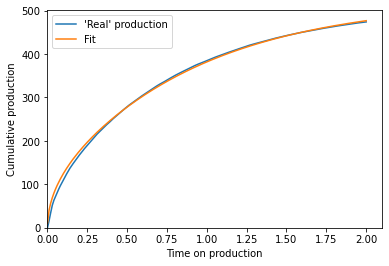

In [5]:
# Forecast cumulative production and compare fit
cum_bestfit = scaling_curve.forecast_cum(time_on_production)

fig, ax = plt.subplots()
ax.plot(time_on_production, cum_production, label="'Real' production")
ax.plot(time_on_production, cum_bestfit, label="Fit")
ax.legend()
ax.set(
    xlim=(0, None),
    ylim=(0, None),
    xlabel="Time on production",
    ylabel="Cumulative production",
);